In [23]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

!pip install transformers
from transformers import AutoModel, AutoTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
print(torch.__version__)

2.0.0+cu118


In [25]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/LSTM


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sns.set_theme()

logging.basicConfig(filename='training_log.log',
                    format='%(asctime)s - %(message)s', 
                    level=logging.INFO,
                    filemode='w')
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='training_log.log', mode='a')
formatter = logging.Formatter('%(asctime)s: %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

In [27]:
class DS(Dataset):
    def __init__(self, data_path, sheet_name, model_ckpt, max_token_length=50):
        super().__init__()
        self.max_token_length = max_token_length

        # label encodings
        self.labels = [
            'hate',
            'privacy',
            'sexual',
            'impersonation',
            'illegal',
            'advertisement',
            'ai',
            'neutral'
        ]

        # load excel
        self.data = pd.read_csv(data_path)
        # self.data = pd.read_csv(data_path)
        # self.data = data.reset_index()

        self.tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.loc[idx, :]


        comment = row['body']
        comment = comment.split()

        # long comments
        if len(comment) > self.max_token_length:
            comment = comment[:45]
        comment = ' '.join(comment)
        comment = comment.replace("\\", "")

        emotion = row['label']
        emotion = self.labels.index(emotion)

        return f"{comment}", emotion

    def choose(self):
        return self[randint(0, len(self)-1)]

    def get_tokenizer_size(self):
        return len(self.tokenizer)

    def decode(self, input_id):
        return self.tokenizer.decode(input_id)

    def collate_fn(self, data):
        comments, emotions = zip(*data)
        comments = self.tokenizer(comments,
                                  padding=True,
                                  return_tensors='pt')
        comments = {k:v.to(device) for k, v in comments.items()}
        emotions = torch.tensor(emotions).long().to(device)
        return comments, emotions

In [31]:
class LSTMClassifier(nn.Module):
    def __init__(self, model_ckpt, nlabels, tokenizer_size=30523):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_ckpt)
        self.encoder.resize_token_embeddings(tokenizer_size)
        encoder_config = self.encoder.config
        self.lstm = nn.LSTM(encoder_config.hidden_size, encoder_config.hidden_size, batch_first=True)
        self.classifier = nn.Sequential(
            nn.LayerNorm(encoder_config.hidden_size),
            nn.Dropout(0.3),
            nn.Linear(encoder_config.hidden_size, nlabels)
        )
    
    def get_summary(self):
        print(self)

    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        # Get the sequence length and batch size
        seq_len, batch_size = x['input_ids'].size()
        # Pass the input through the encoder
        x = self.encoder(**x)
        x = x.last_hidden_state # Shape: (batch_size, seq_len, hidden_size)
        # Pass the encoder output through the LSTM
        x, _ = self.lstm(x)
        # Take the last hidden state of the LSTM as the representation for [CLS]
        x = x[:, -1, :] # Shape: (batch_size, hidden_size)
        # Pass the representation through the classifier
        x = self.classifier(x)
        return x

In [32]:
def compute_metrics(targets, preds):
    targets = targets.cpu().detach()
    preds = preds.cpu().detach()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    return {'acc': acc, 'f1': f1, 'preds': preds, 'targets':targets}

In [33]:
def ft_reg_loss(initial_model):
    init_param = []
    
    for layer in initial_model.parameters():
        init_param.append(layer.clone())
        
    def compute_loss(cur_model):
        loss_p = 0
        cur_param = cur_model.parameters()
        
        for l1, l2, in zip(init_param, cur_param):
            loss_p += torch.sum((l1 - l2)**2)
        
        return loss_p
    
    return compute_loss

In [34]:
def focal_loss(gamma=2):
    def compute_loss(preds, targets):
        ce_loss = F.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(-ce_loss) 
        return ((1-pt)**gamma * ce_loss).mean()
    return compute_loss

In [35]:
def train(data, model, optimizer, label_loss_fn,
          ft_criterion, ft_lambda=1e-4):
    model.train()
    comments, labels = data
    label_outputs = model(comments)
    label_loss = label_loss_fn(label_outputs, labels)
    # ft_loss = ft_criterion(model.encoder)
    loss = label_loss
    model.zero_grad()
    loss.backward()
    optimizer.step()

    label_preds = label_outputs.argmax(-1)
    label_metrics = compute_metrics(labels, label_preds)
    return loss, label_metrics

In [36]:
@torch.no_grad()
def validate(data, model, label_loss_fnn):
    model.eval()
    comments, labels = data
    label_outputs = model(comments)
    label_loss = label_loss_fnn(label_outputs, labels)
    loss = label_loss

    label_preds = label_outputs.argmax(-1)
    label_metrics = compute_metrics(labels, label_preds)
    return loss, label_metrics

In [37]:
data_path = "processed_data.csv"
train_data_path = "train.csv"
val_data_path = "val.csv"
sheet_name = "Sheet1"
df = pd.read_csv("processed_data.csv")
df['label'] = df.iloc[:,1:].idxmax(1)
df = df[['body','label']]


train_df, val_df = train_test_split(df, stratify=df.loc[:, 'label'], test_size=0.1, random_state=123)
train_df.to_csv(train_data_path, index=False)
val_df.to_csv(val_data_path, index=False)
print(f'Size of training data: {len(train_df)}')
print(f'Size of validation data: {len(val_df)}')

Size of training data: 44188
Size of validation data: 4910


In [38]:
# model_ckpt = "GroNLP/hateBERT"
model_ckpt = "bert-base-uncased"
batch_size = 16

train_ds = DS(train_data_path, sheet_name, model_ckpt)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      drop_last=True, collate_fn=train_ds.collate_fn)
val_ds = DS(val_data_path, sheet_name, model_ckpt)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

In [39]:
# model = SingleClassifier(model_ckpt, nlabels=8).to(device)
# model = SingleClassifierCNN(model_ckpt, nlabels=8).to(device)
# model = TransferLearningClassifier(model_ckpt, nlabels=8).to(device)
model = LSTMClassifier(model_ckpt, nlabels=8).to(device)
model.unfreeze_encoder()
#model.get_summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
n_epoch = 10
loss_fn = focal_loss() # nn.CrossEntropyLoss()
ft_criterion = ft_reg_loss(model.encoder)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [41]:
mem = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

cur_best_f1 = 0

for epoch in tqdm(range(10), desc='Training'):

    n_batch = len(train_dl)
    train_losses = []
    train_accs = []
    train_f1s = []

    for i, data in enumerate(train_dl):
        train_loss, train_metrics = train(data, model, optimizer, loss_fn, loss_fn, ft_criterion)
        pos = epoch + ((i+1)/n_batch)
        train_losses.append(train_loss.cpu().detach())
        train_accs.append(train_metrics['acc'])
        train_f1s.append(train_metrics['f1'])
        log = f"epoch: {pos:.3f}\ttrain loss: {train_loss:.3f}\ttrain_acc: {train_metrics['acc']:.3f}\ttrain_f1: {train_metrics['f1']:.3f}"
        print('\r', log, end='')
    
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_acc'].append(np.mean(train_accs))
    mem['train_f1'].append(np.mean(train_f1s))

    n_batch = len(val_dl)
    val_losses = []
    val_accs = []
    val_f1s = []

    for i, data in enumerate(val_dl):
        val_loss, val_metrics = validate(data, model, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        val_losses.append(val_loss.cpu().detach())
        val_accs.append(val_metrics['acc'])
        val_f1s.append(val_metrics['f1'])
        log = f"epoch: {pos:.3f}\tval loss: {val_loss:.3f}\tval_acc: {val_metrics['acc']:.3f}\tval_f1: {val_metrics['f1']:.3f}"
        print('\r', log, end='')
    
    print('\r', end='')
    mem['val_loss'].append(np.mean(val_losses))
    mem['val_acc'].append(np.mean(val_accs))
    mem['val_f1'].append(np.mean(val_f1s))

    log = f"epoch: {epoch+1}\ntrain loss: {mem['train_loss'][-1]:.3f}\ttrain_acc: {mem['train_acc'][-1]:.3f}\ttrain_f1: {mem['train_f1'][-1]:.3f}"
    log = log + f"\nval loss:   {mem['val_loss'][-1]:.3f}\tval_acc:   {mem['val_acc'][-1]:.3f}\tval_f1:   {mem['val_f1'][-1]:.3f}\n"
    logger.info(log)
    print(log)
    scheduler.step()    

    if mem['val_f1'][-1] > cur_best_f1:
        torch.save(model.state_dict(), f"model_weights_bert1.pth")
        cur_best_f1 = mem['val_f1'][-1]

Training:   0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1
train loss: 0.140	train_acc: 0.896	train_f1: 0.891
val loss:   0.087	val_acc:   0.924	val_f1:   0.922

epoch: 2
train loss: 0.069	train_acc: 0.932	train_f1: 0.931
val loss:   0.088	val_acc:   0.931	val_f1:   0.927

epoch: 3
train loss: 0.045	train_acc: 0.947	train_f1: 0.947
val loss:   0.087	val_acc:   0.934	val_f1:   0.931

epoch: 4
train loss: 0.035	train_acc: 0.959	train_f1: 0.958
val loss:   0.096	val_acc:   0.931	val_f1:   0.930

epoch: 5
train loss: 0.026	train_acc: 0.966	train_f1: 0.965
val loss:   0.101	val_acc:   0.930	val_f1:   0.928

epoch: 6
train loss: 0.020	train_acc: 0.973	train_f1: 0.972
val loss:   0.116	val_acc:   0.928	val_f1:   0.926

epoch: 7
train loss: 0.016	train_acc: 0.979	train_f1: 0.979
val loss:   0.108	val_acc:   0.935	val_f1:   0.933

epoch: 8
train loss: 0.011	train_acc: 0.986	train_f1: 0.986
val loss:   0.142	val_acc:   0.929	val_f1:   0.925

epoch: 9
train loss: 0.007	train_acc: 0.991	train_f1: 0.991
val loss:   0.143	val_acc:   0.928	val_f1:  

In [42]:
model_weight = torch.load("model_weights_bert1.pth")
model.load_state_dict(model_weight)

<All keys matched successfully>

In [43]:
label_preds, label_targets = [], []

with torch.no_grad():
    for i, data in tqdm(enumerate(val_dl), total=len(val_dl)):
        comments, labels = data
        label_outputs = model(comments)

        label_preds.extend(label_outputs.argmax(-1).cpu().numpy())
        label_targets.extend(labels.cpu().numpy())


    print("label")

    print(classification_report(label_targets, label_preds))
    

  0%|          | 0/307 [00:00<?, ?it/s]

label
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1958
           1       0.89      0.62      0.73        26
           2       0.68      0.61      0.64        46
           3       0.89      0.62      0.73        26
           4       0.57      0.57      0.57        28
           5       0.88      0.81      0.84        47
           6       0.97      0.99      0.98       604
           7       0.95      0.92      0.94      2175

    accuracy                           0.94      4910
   macro avg       0.84      0.76      0.80      4910
weighted avg       0.93      0.94      0.93      4910



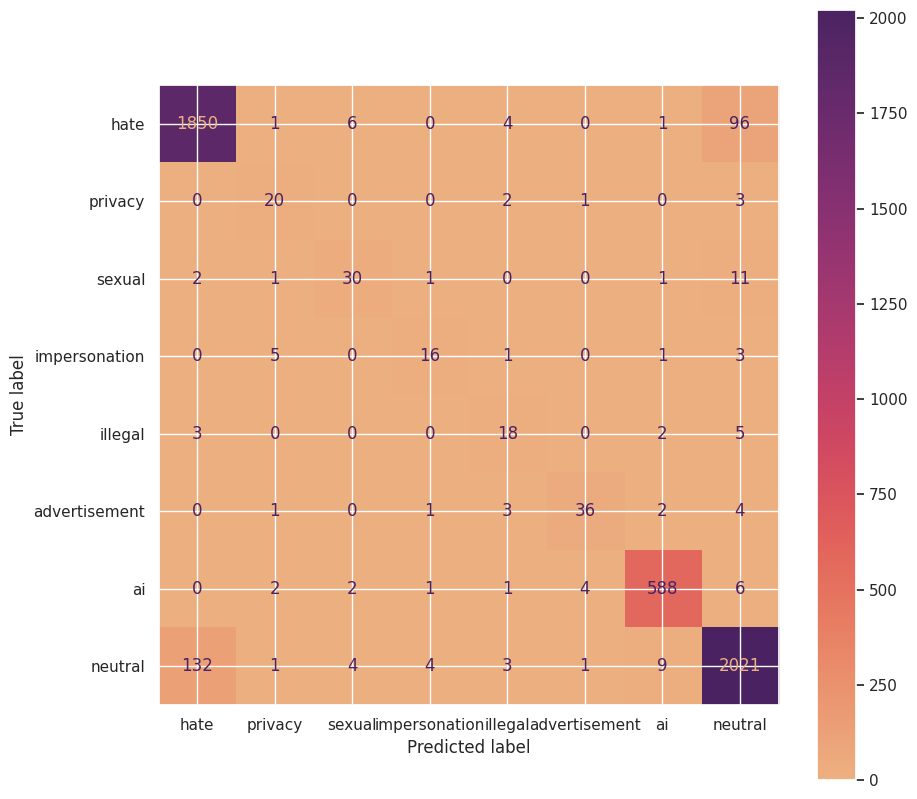

In [22]:
plt.rcParams['figure.figsize'] = [10, 10]
ConfusionMatrixDisplay.from_predictions(label_targets, label_preds,
                                        cmap='flare', 
                                        display_labels=[
            'hate',
            'privacy',
            'sexual',
            'impersonation',
            'illegal',
            'advertisement',
            'ai',
            'neutral'
        ])
plt.show()

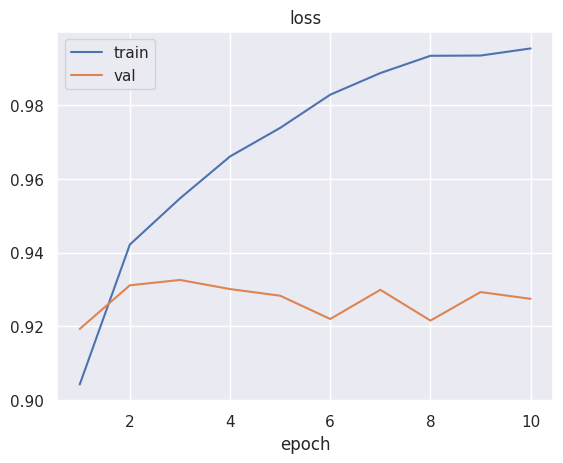

In [21]:
def plot_training_result(mem, metric):
    xticks = [i+1 for i in range(len(mem[f'train_{metric}']))]
    plt.plot(xticks, mem[f'train_{metric}'])
    plt.plot(xticks, mem[f'val_{metric}'])
    plt.legend(['train', 'val'])
    plt.xlabel('epoch')
    plt.title('loss')
    plt.show()
plot_training_result(mem, 'acc')